# Notebook 4: CNN Classifier Training (Transfer Learning)

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** Muhammad Ali Tahir  
**Date:** 2025  

---

## 📋 Notebook Objectives

1. **Load pre-trained encoder** from CAE (Notebook 3)
2. **Build classification head** — Dense layers for 10-class classification
3. **Two-phase training** — Frozen encoder → Fine-tuning
4. **Comprehensive metrics** — Accuracy, Precision, Recall, F1 per epoch
5. **Best practices** — Early stopping, LR scheduling, checkpointing on F1

---

## 🔬 Transfer Learning Strategy

**Phase 1 (Frozen Encoder):** Train only the classification head while keeping encoder weights fixed. This prevents catastrophic forgetting of learned features.

**Phase 2 (Fine-tuning):** Unfreeze encoder and train end-to-end with a lower learning rate. This allows the encoder to adapt features specifically for classification.

---

## 1. Environment Setup & Configuration Loading

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

# Professional metrics
try:
    from torchmetrics.classification import (
        MulticlassAccuracy, MulticlassPrecision,
        MulticlassRecall, MulticlassF1Score
    )
except ImportError:
    print("Installing torchmetrics...")
    !pip install torchmetrics -q
    from torchmetrics.classification import (
        MulticlassAccuracy, MulticlassPrecision,
        MulticlassRecall, MulticlassF1Score
    )

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070 Ti Laptop GPU
Random seed: 42
Notebook executed at: 2026-01-28 11:52:00


In [3]:
# =============================================================================
# LOAD CONFIGURATION FROM PREVIOUS NOTEBOOKS
# =============================================================================

class ProjectPaths:
    """Centralized path management."""
    
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    DATA_RAW = ROOT / "data" / "raw"
    DATA_PROCESSED = ROOT / "data" / "processed"
    NOTEBOOKS = ROOT / "notebooks"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CHECKPOINTS = ROOT / "checkpoints"
    LOGS = ROOT / "logs"
    CONFIG = ROOT / "config"

PATHS = ProjectPaths()

# Load split metadata (from Notebook 2)
metadata_path = PATHS.CONFIG / 'split_metadata.json'
with open(metadata_path, 'r') as f:
    METADATA = json.load(f)

# Load CAE training summary (from Notebook 3)
cae_summary_path = PATHS.CONFIG / 'cae_training_summary.json'
with open(cae_summary_path, 'r') as f:
    CAE_SUMMARY = json.load(f)

# Extract configuration
NORM_MEAN = METADATA['normalization']['mean']
NORM_STD = METADATA['normalization']['std']
IMAGE_SIZE = METADATA['image_config']['size']
NUM_CLASSES = METADATA['classes']['num_classes']
CLASS_NAMES_RAW = METADATA['classes']['names_raw']
CLASS_NAMES = METADATA['classes']['names_display']

print(f"✓ Split metadata loaded")
print(f"✓ CAE summary loaded (Best SSIM: {CAE_SUMMARY['best_ssim']:.4f})")
print(f"\n  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Normalization mean: {[f'{m:.4f}' for m in NORM_MEAN]}")
print(f"  Normalization std:  {[f'{s:.4f}' for s in NORM_STD]}")

✓ Split metadata loaded
✓ CAE summary loaded (Best SSIM: 0.9756)

  Image size: 128×128
  Number of classes: 10
  Normalization mean: ['0.4504', '0.4662', '0.4011']
  Normalization std:  ['0.1742', '0.1514', '0.1907']


In [4]:
# =============================================================================
# TRAINING CONFIGURATION
# =============================================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
CONFIG_CLF = {
    # Data
    'batch_size': 32,
    
    # Phase 1: Frozen encoder
    'phase1_epochs': 15,
    'phase1_lr': 1e-3,
    
    # Phase 2: Fine-tuning (unfrozen)
    'phase2_epochs': 25,
    'phase2_lr': 1e-4,  # Lower LR for fine-tuning
    
    # Regularization
    'weight_decay': 1e-4,
    'dropout': 0.4,
    
    # Early stopping & scheduling
    'patience': 7,
    'lr_patience': 3,
    'lr_factor': 0.5,
    'min_lr': 1e-6,
    
    # Architecture
    'hidden_dim': 512,
    'latent_channels': CAE_SUMMARY['config']['latent_channels'],  # 128 from CAE
}

# Data paths
TRAIN_PATH = PATHS.DATA_PROCESSED / 'train'
VAL_PATH = PATHS.DATA_PROCESSED / 'val'

print("\n" + "="*60)
print("CLASSIFIER TRAINING CONFIGURATION")
print("="*60)
print(f"Device:              {DEVICE}")
print(f"Batch size:          {CONFIG_CLF['batch_size']}")
print(f"\nPhase 1 (Frozen):")
print(f"  Epochs:            {CONFIG_CLF['phase1_epochs']}")
print(f"  Learning rate:     {CONFIG_CLF['phase1_lr']}")
print(f"\nPhase 2 (Fine-tune):")
print(f"  Epochs:            {CONFIG_CLF['phase2_epochs']}")
print(f"  Learning rate:     {CONFIG_CLF['phase2_lr']}")
print(f"\nRegularization:")
print(f"  Weight decay:      {CONFIG_CLF['weight_decay']}")
print(f"  Dropout:           {CONFIG_CLF['dropout']}")
print(f"  Early stop patience: {CONFIG_CLF['patience']}")


CLASSIFIER TRAINING CONFIGURATION
Device:              cuda
Batch size:          32

Phase 1 (Frozen):
  Epochs:            15
  Learning rate:     0.001

Phase 2 (Fine-tune):
  Epochs:            25
  Learning rate:     0.0001

Regularization:
  Weight decay:      0.0001
  Dropout:           0.4
  Early stop patience: 7


---

## 2. Data Pipeline

In [5]:
# =============================================================================
# DATA TRANSFORMS WITH PROPER NORMALIZATION
# =============================================================================

# Training: Augmentation + Normalization (from training set statistics)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)  # From training set!
])

# Validation: Only resize + normalize (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG_CLF['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG_CLF['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\n✓ Training samples:   {len(train_dataset):,}")
print(f"✓ Validation samples: {len(val_dataset):,}")
print(f"✓ Training batches:   {len(train_loader):,}")
print(f"✓ Validation batches: {len(val_loader):,}")
print(f"\n✓ Using normalization from TRAINING SET (no data leakage)")


✓ Training samples:   14,528
✓ Validation samples: 1,816
✓ Training batches:   454
✓ Validation batches: 57

✓ Using normalization from TRAINING SET (no data leakage)


---

## 3. Model Architecture

In [6]:
# =============================================================================
# ENCODER ARCHITECTURE (MUST MATCH CAE)
# =============================================================================

class Encoder(nn.Module):
    """
    Encoder architecture matching the CAE from Notebook 3.
    
    Input:  [B, 3, 128, 128]
    Output: [B, 128, 16, 16]
    """
    
    def __init__(self, latent_channels=128):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # Block 1: 128×128×3 → 64×64×32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 2: 64×64×32 → 32×32×64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Block 3: 32×32×64 → 16×16×128
            nn.Conv2d(64, latent_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.encoder(x)

In [7]:
# =============================================================================
# CLASSIFIER ARCHITECTURE
# =============================================================================

class TomatoClassifier(nn.Module):
    """
    Classification model using pre-trained CAE encoder.
    
    Architecture:
        - Pre-trained encoder (from CAE)
        - Global Average Pooling (optional, more robust)
        - Classification head with dropout
    
    Input:  [B, 3, 128, 128]
    Output: [B, num_classes]
    """
    
    def __init__(self, encoder, num_classes, hidden_dim=512, dropout=0.4, use_gap=False):
        super(TomatoClassifier, self).__init__()
        
        self.encoder = encoder
        self.use_gap = use_gap
        
        if use_gap:
            # Global Average Pooling approach (more robust, fewer params)
            self.gap = nn.AdaptiveAvgPool2d(1)
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
        else:
            # Flatten approach (matches your original)
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * 16 * 16, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
    
    def forward(self, x):
        features = self.encoder(x)
        if self.use_gap:
            features = self.gap(features)
        return self.classifier(features)
    
    def freeze_encoder(self):
        """Freeze encoder weights for Phase 1 training."""
        for param in self.encoder.parameters():
            param.requires_grad = False
        print("✓ Encoder frozen")
    
    def unfreeze_encoder(self):
        """Unfreeze encoder weights for Phase 2 fine-tuning."""
        for param in self.encoder.parameters():
            param.requires_grad = True
        print("✓ Encoder unfrozen")
    
    def get_trainable_params(self):
        """Return count of trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
# =============================================================================
# LOAD PRE-TRAINED ENCODER AND BUILD CLASSIFIER
# =============================================================================

# Create encoder
encoder = Encoder(latent_channels=CONFIG_CLF['latent_channels'])

# Load pre-trained weights from CAE
encoder_path = PATHS.MODELS / 'cae_encoder.pth'
checkpoint = torch.load(encoder_path, map_location=DEVICE)

# Load encoder state dict
encoder.encoder.load_state_dict(checkpoint['encoder_state_dict'])

print(f"✓ Loaded pre-trained encoder from: {encoder_path}")
print(f"  CAE trained for {checkpoint['training_epochs']} epochs")
print(f"  CAE best SSIM: {checkpoint['best_ssim']:.4f}")
print(f"  CAE best PSNR: {checkpoint['best_psnr']:.2f} dB")

# Build classifier
model = TomatoClassifier(
    encoder=encoder,
    num_classes=NUM_CLASSES,
    hidden_dim=CONFIG_CLF['hidden_dim'],
    dropout=CONFIG_CLF['dropout'],
    use_gap=False  # Set to True for GAP approach
).to(DEVICE)

# Print architecture
print("\n" + "="*60)
print("CLASSIFIER ARCHITECTURE")
print("="*60)
print(model)

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
encoder_params = sum(p.numel() for p in model.encoder.parameters())
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print("\n" + "-"*60)
print("PARAMETER COUNT")
print("-"*60)
print(f"Encoder parameters:    {encoder_params:,}")
print(f"Classifier parameters: {classifier_params:,}")
print(f"Total parameters:      {total_params:,}")

✓ Loaded pre-trained encoder from: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/cae_encoder.pth
  CAE trained for 50 epochs
  CAE best SSIM: 0.9756
  CAE best PSNR: 40.62 dB

CLASSIFIER ARCHITECTURE
TomatoClassifier(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, o

---

## 4. Training Setup

In [9]:
# =============================================================================
# LOSS FUNCTION AND METRICS
# =============================================================================

# Loss function
criterion = nn.CrossEntropyLoss()

# Metrics (torchmetrics)
metrics = {
    'accuracy': MulticlassAccuracy(num_classes=NUM_CLASSES).to(DEVICE),
    'precision': MulticlassPrecision(num_classes=NUM_CLASSES, average='macro').to(DEVICE),
    'recall': MulticlassRecall(num_classes=NUM_CLASSES, average='macro').to(DEVICE),
    'f1': MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(DEVICE),
}

print("✓ Loss: CrossEntropyLoss")
print("✓ Metrics: Accuracy, Precision, Recall, F1 (Macro)")

✓ Loss: CrossEntropyLoss
✓ Metrics: Accuracy, Precision, Recall, F1 (Macro)


In [10]:
# =============================================================================
# TRAINING HISTORY TRACKER
# =============================================================================

class ClassifierHistory:
    """Track all training metrics."""
    
    def __init__(self):
        self.history = {
            'epoch': [],
            'phase': [],
            'train_loss': [],
            'val_loss': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'learning_rate': [],
            'epoch_time': [],
        }
        self.best_f1 = 0
        self.best_accuracy = 0
        self.best_epoch = 0
        self.total_time = 0
    
    def update(self, epoch, phase, train_loss, val_loss, acc, prec, rec, f1, lr, time):
        self.history['epoch'].append(epoch)
        self.history['phase'].append(phase)
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['accuracy'].append(acc)
        self.history['precision'].append(prec)
        self.history['recall'].append(rec)
        self.history['f1'].append(f1)
        self.history['learning_rate'].append(lr)
        self.history['epoch_time'].append(time)
        self.total_time += time
        
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_epoch = epoch
        if acc > self.best_accuracy:
            self.best_accuracy = acc
    
    def get_dataframe(self):
        return pd.DataFrame(self.history)
    
    def save(self, filepath):
        df = self.get_dataframe()
        df.to_csv(filepath, index=False)
        print(f"✓ Training history saved: {filepath}")

# Initialize
history = ClassifierHistory()

In [11]:
# =============================================================================
# TRAINING AND VALIDATION FUNCTIONS
# =============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)


def validate_epoch(model, loader, criterion, metrics, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(labels)
    
    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Compute metrics
    acc = metrics['accuracy'](all_preds, all_labels).item()
    prec = metrics['precision'](all_preds, all_labels).item()
    rec = metrics['recall'](all_preds, all_labels).item()
    f1 = metrics['f1'](all_preds, all_labels).item()
    
    return running_loss / len(loader), acc, prec, rec, f1, all_preds, all_labels

---

## 5. Training Loop (Two-Phase)

In [12]:
# =============================================================================
# PHASE 1: FROZEN ENCODER (Train only classifier head)
# =============================================================================

print("\n" + "="*80)
print("PHASE 1: TRAINING WITH FROZEN ENCODER")
print("="*80)

# Freeze encoder
model.freeze_encoder()
print(f"Trainable parameters: {model.get_trainable_params():,}")

# Optimizer for Phase 1 (only classifier parameters)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG_CLF['phase1_lr'],
    weight_decay=CONFIG_CLF['weight_decay']
)

scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=CONFIG_CLF['lr_factor'],
    patience=CONFIG_CLF['lr_patience'], min_lr=CONFIG_CLF['min_lr']
)

# Early stopping
best_f1 = 0
early_stop_counter = 0
checkpoint_path = PATHS.CHECKPOINTS / 'classifier_best.pth'

print(f"\nStarting Phase 1 training ({CONFIG_CLF['phase1_epochs']} epochs)...\n")

for epoch in range(1, CONFIG_CLF['phase1_epochs'] + 1):
    epoch_start = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, acc, prec, rec, f1, _, _ = validate_epoch(
        model, val_loader, criterion, metrics, DEVICE
    )
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history.update(epoch, 'frozen', train_loss, val_loss, acc, prec, rec, f1, current_lr, epoch_time)
    
    # Update scheduler (based on F1)
    scheduler.step(f1)
    
    # Print progress
    print(f"Epoch [{epoch:02d}/{CONFIG_CLF['phase1_epochs']}] "
          f"Loss: {val_loss:.4f} | "
          f"Acc: {acc:.2%} | "
          f"F1: {f1:.4f} | "
          f"Prec: {prec:.4f} | "
          f"Rec: {rec:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Checkpoint on best F1
    if f1 > best_f1:
        best_f1 = f1
        early_stop_counter = 0
        torch.save({
            'epoch': epoch,
            'phase': 'frozen',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': f1,
            'accuracy': acc,
            'config': CONFIG_CLF
        }, checkpoint_path)
        print(f"  └─ ✓ Checkpoint saved (F1: {f1:.4f})")
    else:
        early_stop_counter += 1
        print(f"  └─ No improvement ({early_stop_counter}/{CONFIG_CLF['patience']})")
        
        if early_stop_counter >= CONFIG_CLF['patience']:
            print(f"\n[INFO] Early stopping triggered at epoch {epoch}")
            break

print(f"\nPhase 1 complete. Best F1: {best_f1:.4f}")


PHASE 1: TRAINING WITH FROZEN ENCODER
✓ Encoder frozen
Trainable parameters: 16,783,882

Starting Phase 1 training (15 epochs)...

Epoch [01/15] Loss: 0.8086 | Acc: 64.07% | F1: 0.5822 | Prec: 0.6852 | Rec: 0.6407 | Time: 9.2s
  └─ ✓ Checkpoint saved (F1: 0.5822)
Epoch [02/15] Loss: 0.7736 | Acc: 66.87% | F1: 0.6397 | Prec: 0.7224 | Rec: 0.6687 | Time: 8.5s
  └─ ✓ Checkpoint saved (F1: 0.6397)
Epoch [03/15] Loss: 0.7411 | Acc: 65.19% | F1: 0.6409 | Prec: 0.7291 | Rec: 0.6519 | Time: 8.5s
  └─ ✓ Checkpoint saved (F1: 0.6409)
Epoch [04/15] Loss: 0.7573 | Acc: 65.61% | F1: 0.6601 | Prec: 0.7728 | Rec: 0.6561 | Time: 8.3s
  └─ ✓ Checkpoint saved (F1: 0.6601)
Epoch [05/15] Loss: 0.6317 | Acc: 73.64% | F1: 0.7192 | Prec: 0.7625 | Rec: 0.7364 | Time: 8.2s
  └─ ✓ Checkpoint saved (F1: 0.7192)
Epoch [06/15] Loss: 0.5566 | Acc: 74.11% | F1: 0.7299 | Prec: 0.7802 | Rec: 0.7411 | Time: 8.2s
  └─ ✓ Checkpoint saved (F1: 0.7299)
Epoch [07/15] Loss: 0.7155 | Acc: 68.15% | F1: 0.6552 | Prec: 0.7218 |

In [13]:
# =============================================================================
# PHASE 2: FINE-TUNING (Unfreeze encoder)
# =============================================================================

print("\n" + "="*80)
print("PHASE 2: FINE-TUNING WITH UNFROZEN ENCODER")
print("="*80)

# Load best checkpoint from Phase 1
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best Phase 1 model (F1: {checkpoint['f1']:.4f})")

# Unfreeze encoder
model.unfreeze_encoder()
print(f"Trainable parameters: {model.get_trainable_params():,}")

# New optimizer with lower LR for fine-tuning
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG_CLF['phase2_lr'],
    weight_decay=CONFIG_CLF['weight_decay']
)

scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=CONFIG_CLF['lr_factor'],
    patience=CONFIG_CLF['lr_patience'], min_lr=CONFIG_CLF['min_lr']
)

# Reset early stopping
early_stop_counter = 0
phase1_epochs = len([e for e in history.history['phase'] if e == 'frozen'])

print(f"\nStarting Phase 2 training ({CONFIG_CLF['phase2_epochs']} epochs)...\n")

for epoch in range(1, CONFIG_CLF['phase2_epochs'] + 1):
    global_epoch = phase1_epochs + epoch
    epoch_start = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, acc, prec, rec, f1, _, _ = validate_epoch(
        model, val_loader, criterion, metrics, DEVICE
    )
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history.update(global_epoch, 'finetune', train_loss, val_loss, acc, prec, rec, f1, current_lr, epoch_time)
    
    # Update scheduler
    scheduler.step(f1)
    
    # Print progress
    print(f"Epoch [{epoch:02d}/{CONFIG_CLF['phase2_epochs']}] (Global: {global_epoch}) "
          f"Loss: {val_loss:.4f} | "
          f"Acc: {acc:.2%} | "
          f"F1: {f1:.4f} | "
          f"Prec: {prec:.4f} | "
          f"Rec: {rec:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Checkpoint on best F1
    if f1 > best_f1:
        best_f1 = f1
        early_stop_counter = 0
        torch.save({
            'epoch': global_epoch,
            'phase': 'finetune',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'config': CONFIG_CLF
        }, checkpoint_path)
        print(f"  └─ ✓ Checkpoint saved (F1: {f1:.4f})")
    else:
        early_stop_counter += 1
        print(f"  └─ No improvement ({early_stop_counter}/{CONFIG_CLF['patience']})")
        
        if early_stop_counter >= CONFIG_CLF['patience']:
            print(f"\n[INFO] Early stopping triggered at epoch {epoch}")
            break

# Training complete
print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Total epochs:        {len(history.history['epoch'])}")
print(f"Total training time: {timedelta(seconds=int(history.total_time))}")
print(f"Best epoch:          {history.best_epoch}")
print(f"Best F1 Score:       {history.best_f1:.4f}")
print(f"Best Accuracy:       {history.best_accuracy:.2%}")


PHASE 2: FINE-TUNING WITH UNFROZEN ENCODER
✓ Loaded best Phase 1 model (F1: 0.7711)
✓ Encoder unfrozen
Trainable parameters: 16,877,578

Starting Phase 2 training (25 epochs)...

Epoch [01/25] (Global: 16) Loss: 0.7200 | Acc: 70.26% | F1: 0.7177 | Prec: 0.8062 | Rec: 0.7026 | Time: 8.4s
  └─ No improvement (1/7)
Epoch [02/25] (Global: 17) Loss: 0.3423 | Acc: 83.99% | F1: 0.8448 | Prec: 0.8625 | Rec: 0.8399 | Time: 8.5s
  └─ ✓ Checkpoint saved (F1: 0.8448)
Epoch [03/25] (Global: 18) Loss: 0.3145 | Acc: 85.33% | F1: 0.8490 | Prec: 0.8589 | Rec: 0.8533 | Time: 8.3s
  └─ ✓ Checkpoint saved (F1: 0.8490)
Epoch [04/25] (Global: 19) Loss: 0.2538 | Acc: 88.22% | F1: 0.8913 | Prec: 0.9053 | Rec: 0.8822 | Time: 8.4s
  └─ ✓ Checkpoint saved (F1: 0.8913)
Epoch [05/25] (Global: 20) Loss: 0.2212 | Acc: 88.88% | F1: 0.8952 | Prec: 0.9061 | Rec: 0.8888 | Time: 8.2s
  └─ ✓ Checkpoint saved (F1: 0.8952)
Epoch [06/25] (Global: 21) Loss: 0.2104 | Acc: 91.23% | F1: 0.9123 | Prec: 0.9152 | Rec: 0.9123 | Tim

---

## 6. Training Visualization

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_14_classifier_training_curves.png


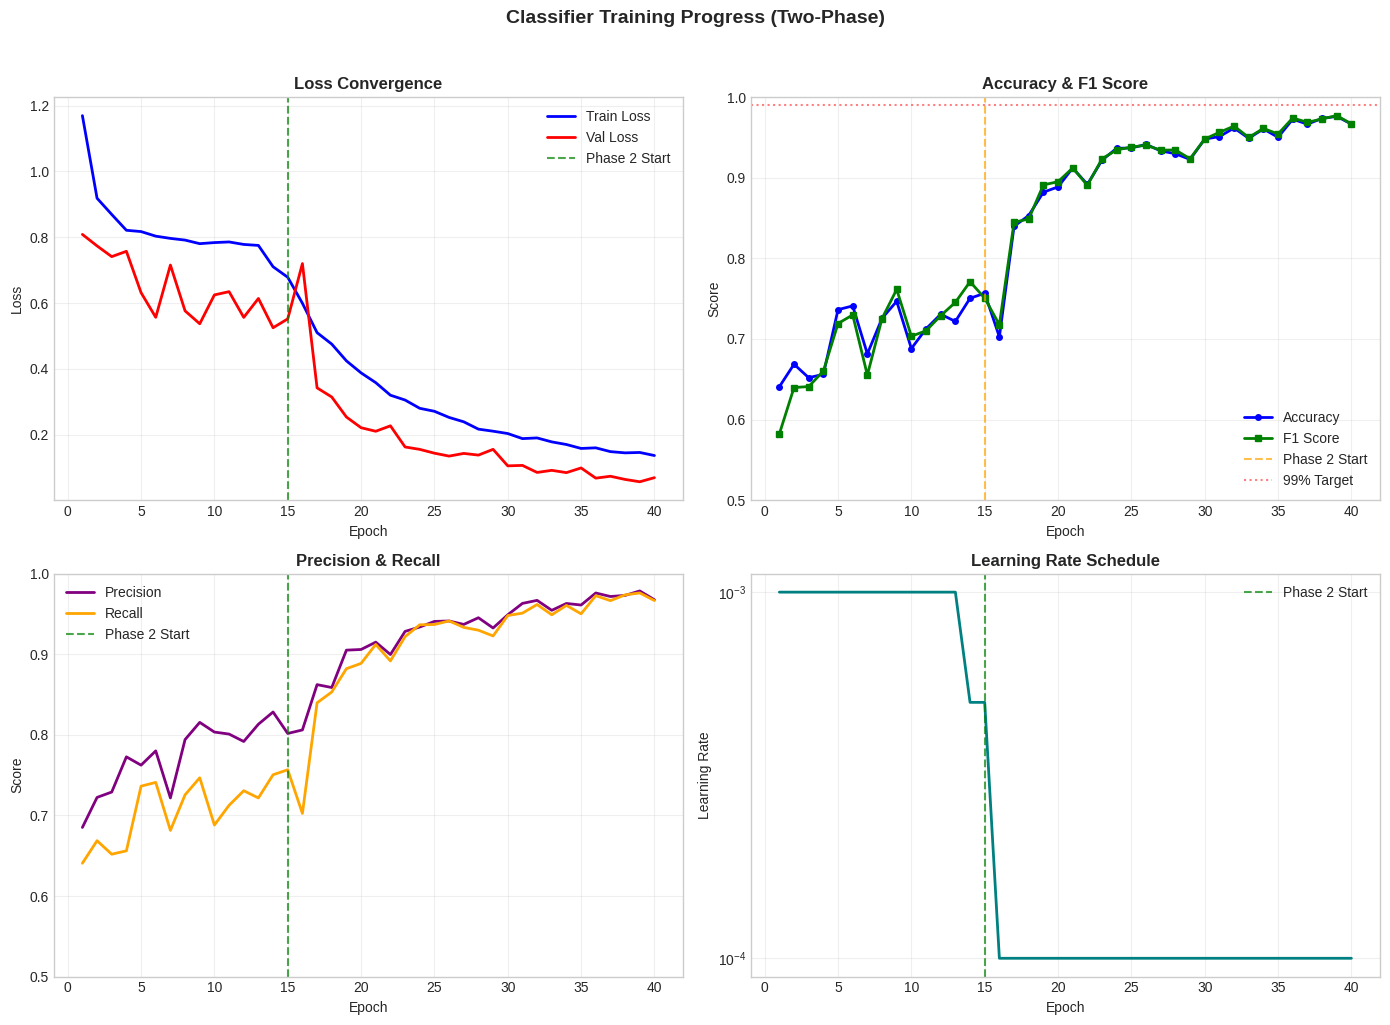

In [14]:
# =============================================================================
# PLOT TRAINING CURVES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = history.history['epoch']
phase1_end = len([p for p in history.history['phase'] if p == 'frozen'])

# Plot 1: Loss
ax1 = axes[0, 0]
ax1.plot(epochs, history.history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.axvline(x=phase1_end, color='green', linestyle='--', alpha=0.7, label='Phase 2 Start')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Convergence', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy & F1
ax2 = axes[0, 1]
ax2.plot(epochs, history.history['accuracy'], 'b-', label='Accuracy', linewidth=2, marker='o', markersize=4)
ax2.plot(epochs, history.history['f1'], 'g-', label='F1 Score', linewidth=2, marker='s', markersize=4)
ax2.axvline(x=phase1_end, color='orange', linestyle='--', alpha=0.7, label='Phase 2 Start')
ax2.axhline(y=0.99, color='red', linestyle=':', alpha=0.5, label='99% Target')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('Accuracy & F1 Score', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_ylim(0.5, 1.0)
ax2.grid(True, alpha=0.3)

# Plot 3: Precision & Recall
ax3 = axes[1, 0]
ax3.plot(epochs, history.history['precision'], 'purple', label='Precision', linewidth=2)
ax3.plot(epochs, history.history['recall'], 'orange', label='Recall', linewidth=2)
ax3.axvline(x=phase1_end, color='green', linestyle='--', alpha=0.7, label='Phase 2 Start')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.set_title('Precision & Recall', fontsize=12, fontweight='bold')
ax3.legend()
ax3.set_ylim(0.5, 1.0)
ax3.grid(True, alpha=0.3)

# Plot 4: Learning Rate
ax4 = axes[1, 1]
ax4.plot(epochs, history.history['learning_rate'], 'teal', linewidth=2)
ax4.axvline(x=phase1_end, color='green', linestyle='--', alpha=0.7, label='Phase 2 Start')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Classifier Training Progress (Two-Phase)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_14_classifier_training_curves.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

---

## 7. Final Evaluation

In [15]:
# =============================================================================
# LOAD BEST MODEL
# =============================================================================

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']} (Phase: {checkpoint['phase']})")
print(f"  F1 Score: {checkpoint['f1']:.4f}")
print(f"  Accuracy: {checkpoint['accuracy']:.2%}")

✓ Loaded best model from epoch 39 (Phase: finetune)
  F1 Score: 0.9774
  Accuracy: 97.63%


✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_15_confusion_matrix.png


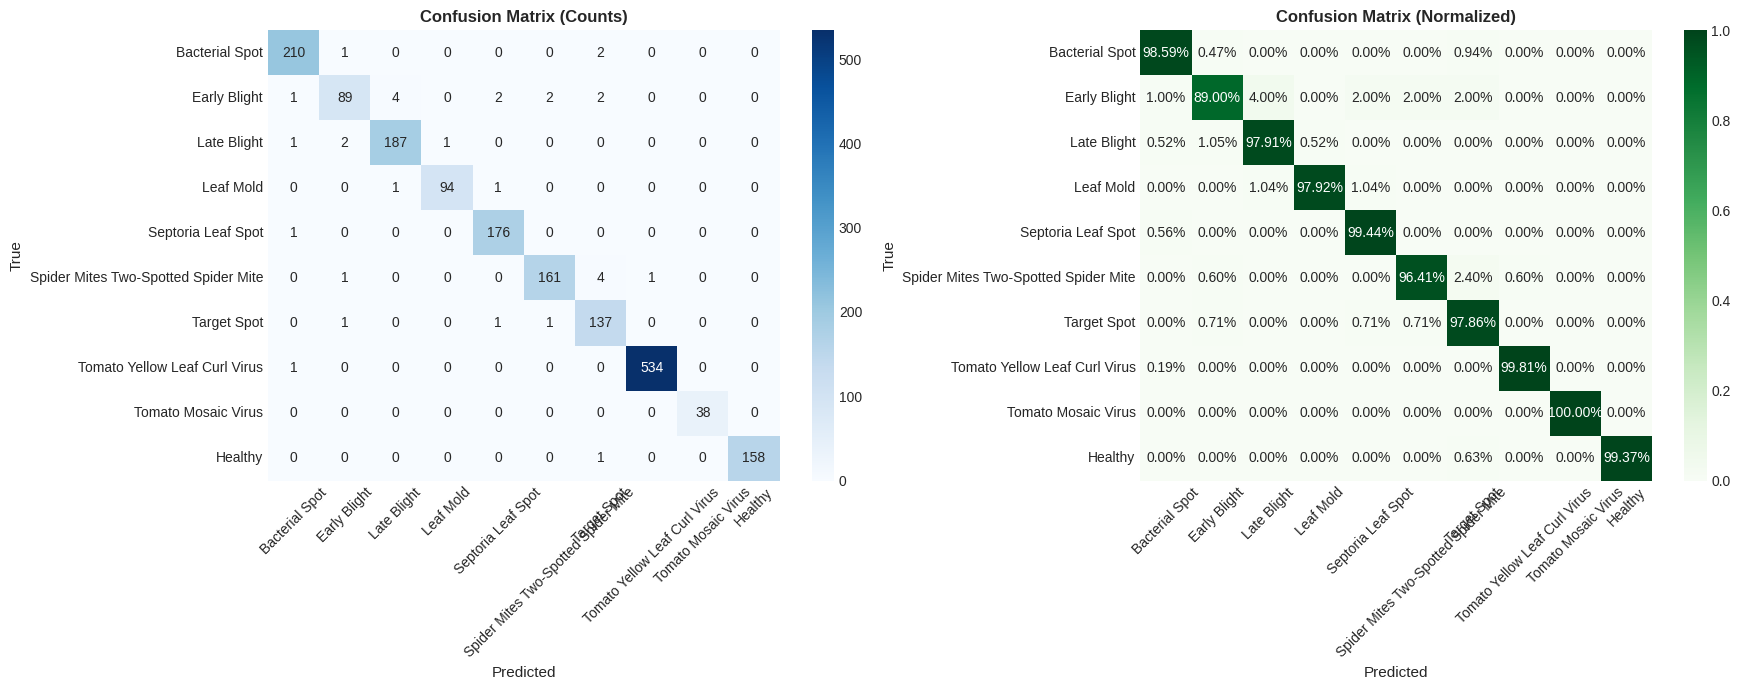

In [16]:
# =============================================================================
# CONFUSION MATRIX ON VALIDATION SET
# =============================================================================

# Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('True', fontsize=11)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('True', fontsize=11)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()

# Save
fig_path = PATHS.OUTPUTS / 'fig_15_confusion_matrix.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Figure saved: {fig_path}")

plt.show()

In [17]:
# =============================================================================
# CLASSIFICATION REPORT
# =============================================================================

print("\n" + "="*80)
print("CLASSIFICATION REPORT (Validation Set)")
print("="*80 + "\n")

report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4)
print(report)

# Save report
report_dict = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_path = PATHS.LOGS / 'classification_report_val.csv'
report_df.to_csv(report_path)
print(f"\n✓ Report saved: {report_path}")


CLASSIFICATION REPORT (Validation Set)

                                      precision    recall  f1-score   support

                      Bacterial Spot     0.9813    0.9859    0.9836       213
                        Early Blight     0.9468    0.8900    0.9175       100
                         Late Blight     0.9740    0.9791    0.9765       191
                           Leaf Mold     0.9895    0.9792    0.9843        96
                  Septoria Leaf Spot     0.9778    0.9944    0.9860       177
Spider Mites Two-Spotted Spider Mite     0.9817    0.9641    0.9728       167
                         Target Spot     0.9384    0.9786    0.9580       140
       Tomato Yellow Leaf Curl Virus     0.9981    0.9981    0.9981       535
                 Tomato Mosaic Virus     1.0000    1.0000    1.0000        38
                             Healthy     1.0000    0.9937    0.9968       159

                            accuracy                         0.9824      1816
                     

---

## 8. Save Final Model & Export

In [18]:
# =============================================================================
# SAVE FINAL MODEL
# =============================================================================

# Save full model for inference
final_model_path = PATHS.MODELS / 'classifier_final.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'class_names_raw': CLASS_NAMES_RAW,
    'image_size': IMAGE_SIZE,
    'normalization': {'mean': NORM_MEAN, 'std': NORM_STD},
    'best_f1': history.best_f1,
    'best_accuracy': history.best_accuracy,
    'config': CONFIG_CLF
}, final_model_path)

print(f"✓ Final model saved: {final_model_path}")

✓ Final model saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/classifier_final.pth


In [19]:
# =============================================================================
# SAVE TRAINING HISTORY & SUMMARY
# =============================================================================

# Save history
history_path = PATHS.LOGS / 'classifier_training_history.csv'
history.save(history_path)

# Training summary
training_summary = {
    'completed_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_epochs': len(history.history['epoch']),
    'total_training_time_seconds': history.total_time,
    'total_training_time_formatted': str(timedelta(seconds=int(history.total_time))),
    'best_epoch': history.best_epoch,
    'best_f1': history.best_f1,
    'best_accuracy': history.best_accuracy,
    'phase1_epochs': len([p for p in history.history['phase'] if p == 'frozen']),
    'phase2_epochs': len([p for p in history.history['phase'] if p == 'finetune']),
    'config': CONFIG_CLF,
    'model_paths': {
        'final_model': str(final_model_path),
        'checkpoint': str(checkpoint_path)
    }
}

summary_path = PATHS.CONFIG / 'classifier_training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"✓ Training summary saved: {summary_path}")

# Display summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(json.dumps(training_summary, indent=2))

✓ Training history saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/logs/classifier_training_history.csv
✓ Training summary saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/config/classifier_training_summary.json

TRAINING SUMMARY
{
  "completed_date": "2026-01-28 11:57:48",
  "total_epochs": 40,
  "total_training_time_seconds": 332.30332255363464,
  "total_training_time_formatted": "0:05:32",
  "best_epoch": 39,
  "best_f1": 0.9773749113082886,
  "best_accuracy": 0.9762974977493286,
  "phase1_epochs": 15,
  "phase2_epochs": 25,
  "config": {
    "batch_size": 32,
    "phase1_epochs": 15,
    "phase1_lr": 0.001,
    "phase2_epochs": 25,
    "phase2_lr": 0.0001,
    "weight_decay": 0.0001,
    "dropout": 0.4,
    "patience": 7,
    "lr_patience": 3,
    "lr_factor": 0.5,
    "min_lr": 1e-06,
    "hidden_dim": 512,
    "latent_channels": 128
  },
  "model_paths": {
    "final_model": "/home/maliciit/ml-projects/python-projects/plant-village-cae/model

---

## 9. Summary & Next Steps

### ✅ Completed in This Notebook

1. **Loaded pre-trained encoder** from CAE (Notebook 3)
2. **Two-phase training:**
   - Phase 1: Frozen encoder (train classifier head only)
   - Phase 2: Fine-tuning (end-to-end with lower LR)
3. **Comprehensive metrics:** Accuracy, Precision, Recall, F1 per epoch
4. **Confusion matrix & classification report**
5. **Model export** for inference

### 📊 Key Results

| Metric | Value |
|--------|-------|
| Best F1 Score | See summary above |
| Best Accuracy | See summary above |
| Training Time | See summary above |

### 📁 Files Created

- `models/classifier_final.pth` — Final model for inference
- `checkpoints/classifier_best.pth` — Best checkpoint
- `logs/classifier_training_history.csv` — Epoch metrics
- `logs/classification_report_val.csv` — Per-class metrics
- `config/classifier_training_summary.json` — Training config & results

### ➡️ Next Notebook: `5_Threshold_Optimization_and_Evaluation.ipynb`

- Evaluate on TEST set (held-out data)
- Threshold optimization for precision/recall trade-off
- t-SNE visualization of learned features
- Final scientific figures for publication

In [20]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*60)
print("✓ NOTEBOOK 4 COMPLETE")
print("="*60)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nBest F1 Score: {history.best_f1:.4f}")
print(f"Best Accuracy: {history.best_accuracy:.2%}")
print("\nProceed to: 5_Threshold_Optimization_and_Evaluation.ipynb")


✓ NOTEBOOK 4 COMPLETE
Execution finished at: 2026-01-28 11:57:48

Best F1 Score: 0.9774
Best Accuracy: 97.63%

Proceed to: 5_Threshold_Optimization_and_Evaluation.ipynb
